In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
### 1 or 2###
# 1
"""
try:
  !pip install -q tf-nightly
except Exception:
  pass
"""
# end 1

# 2
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
# end 2

import tensorflow as tf
import tensorflow_datasets as tfds

import time
import numpy as np
import matplotlib.pyplot as plt

import io
import os
from sklearn.model_selection import train_test_split

SOS = '<start>'
EOS = '<end>'

In [0]:
def tokenize(lang, target_vocab_size, vocab_filename = None):
  """
  Create a custom subwords tokenizer from the training dataset (lang).
  The tokenizer encodes the string by breaking it into subwords if the word is not in its dictionary.
  """
  tokenizer = None
  if vocab_filename :
    if os.path.exists(vocab_filename):
      # charger a partir du fichier specifié (pour gagner en temps)
      tokenizer = tfds.features.text.SubwordTextEncoder.load_from_file(vocab_filename)
    else :
      # construire et charger dans le fichier specifié (pour des futures chargements)
      tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(lang, target_vocab_size = target_vocab_size)
      tokenizer.save_to_file(vocab_filename)
  else :
    # construire juste (deprecié)
    tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(lang, target_vocab_size = target_vocab_size)
  """
  Exemple : english corpus

  sample_string = 'Transformer is awesome.'

  tokenized_string = tokenizer.encode(sample_string)
  print(tokenized_string) # [7915, 1248, 7946, 7194, 13, 2799, 7877]

  original_string = tokenizer.decode(tokenized_string)
  print(original_string) # Transformer is awesome.

  for ts in tokenized_string:
    print ('{} ----> {}'.format(ts, tokenizer_en.decode([ts])))

  7915 ----> T
  1248 ----> ran
  7946 ----> s
  7194 ----> former 
  13 ----> is 
  2799 ----> awesome
  7877 ----> .
  """
  return tokenizer

def create_dataset(path, sentencesSeparator):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
  lines = [e.split(sentencesSeparator) for e in lines]
  return lines

def py_function(tokenizer_input_lang, tokenizer_target_lang):
    
  def encode(input_sample, target_sample):
    """
    Add a start and end token to the input and target.
    encode(start) = vocab_size
    encode(end) = vocab_size + 1
    """
    #input_sample = [tokenizer_input_lang.vocab_size] + tokenizer_input_lang.encode(input_sample.numpy()) + [tokenizer_input_lang.vocab_size+1]
    #target_sample = [tokenizer_target_lang.vocab_size] + tokenizer_target_lang.encode(target_sample.numpy()) + [tokenizer_target_lang.vocab_size+1]
      
    return input_sample, target_sample

  def tf_encode(input_lang, target_lang) :
    """
    You want to use Dataset.map to apply this function to each element of the dataset. Dataset.map runs in graph mode.
    Graph tensors do not have a value.
    In graph mode you can only use TensorFlow Ops and functions.
    So you can't .map this function directly: You need to wrap it in a tf.py_function. 
    The tf.py_function will pass regular tensors (with a value and a .numpy() method to access it), to the wrapped python function.
    """
    result_input_lang, result_target_lang = tf.py_function(encode, [input_lang, target_lang], [tf.int32, tf.int32])
    result_input_lang.set_shape([None])
    result_target_lang.set_shape([None])
    return result_input_lang, result_target_lang 
    
  return tf_encode

def filter_max_length(x, y, max_length = 50):
  return tf.logical_and(tf.size(x) <= max_length, tf.size(y) <= max_length)

In [0]:
def load_dataset(path, sentencesSeparator, input_vocab_filename, target_vocab_filename, MAX_LENGTH, BUFFER_SIZE, BATCH_SIZE, 
                  target_vocab_size, test_size, val_size, num_examples = None, shift_EOS=False):
  
  lines = create_dataset(path, sentencesSeparator)
  
  dataset = tf.data.Dataset.from_tensor_slices(lines)

  tokenizer_input_lang = tokenize((text.numpy() for text, _ in dataset), vocab_filename = input_vocab_filename, target_vocab_size = target_vocab_size)
  tokenizer_target_lang = tokenize((text.numpy() for _, text in dataset), vocab_filename = target_vocab_filename, target_vocab_size = target_vocab_size)
  
  # Add a start and end token to the input and target.
  """
  encode(start) = vocab_size
  encode(end) = vocab_size + 1
  """
  train_examples = [
                    [
                      [tokenizer_input_lang.vocab_size] + tokenizer_input_lang.encode(e[0]) + [tokenizer_input_lang.vocab_size+1], 
                      [tokenizer_target_lang.vocab_size] + tokenizer_target_lang.encode(e[1]) + [tokenizer_target_lang.vocab_size+1]
                    ]
                    for e in lines
                   ]
  """
  train_examples = [
                    [
                      tokenizer_input_lang.encode(e[0]), 
                      tokenizer_target_lang.encode(e[1])
                    ]
                    for e in lines
                   ]
  """
  max_length = max([max(len(e[0]), len(e[1])) for e in train_examples])
  max_length = max(MAX_LENGTH, max_length)
  
  np.random.shuffle(train_examples)

  if num_examples :
      train_examples = train_examples[:num_examples]

  def pad(sample):
    a, b, end = sample[0], sample[1], []
    l1, l2 = len(a), len(b)
    #max_length = max(l1, l2)
    if shift_EOS :
        end = [a[-1]]
        a = a[:l1-1]
        b = b[:l2-1]
    a = a + [0 for _ in range(max_length - l1)] + end
    b = b + [0 for _ in range(max_length - l2)] + end
    return [a, b]

  train_examples = [pad(e) for e in train_examples]

  test_examples, val_examples = None, None
  if 0 < test_size :
    # Une exception est levée si tres peu de données
    try :
      train_examples, test_examples = train_test_split(train_examples, test_size = test_size)
    except :
      pass
  if 0 < val_size :
    try :
      train_examples, val_examples = train_test_split(train_examples, test_size = val_size)
    except :
      pass

  def tf_rechape(inp, tar):
    inp.set_shape([None])
    tar.set_shape([None])
    return inp, tar

  def from_tf_dataset(examples, train_one = False):
    targ_lang, inp_lang = zip(*examples)
    targ_lang = tf.keras.preprocessing.sequence.pad_sequences(targ_lang, padding='post')
    inp_lang = tf.keras.preprocessing.sequence.pad_sequences(inp_lang, padding='post')
    dataset = tf.data.Dataset.from_tensor_slices((inp_lang, targ_lang))
    #dataset = dataset.map(tf_rechape)
    dataset = dataset.map(py_function(tokenizer_input_lang, tokenizer_target_lang))
    
    if train_one :
      # cache the dataset to memory to get a speedup while reading from it.
      dataset = dataset.cache()
      # shuffle
      BUFFER_SIZE = len(targ_lang)
      dataset = dataset.shuffle(BUFFER_SIZE)
      # Pad and batch examples together
      dataset = dataset.padded_batch(BATCH_SIZE)
      """
      Creates a Dataset that prefetches elements from this dataset.
      Most dataset input pipelines should end with a call to prefetch. 
      This allows later elements to be prepared while the current element is being processed. 
      This often improves latency and throughput, at the cost of using additional memory to store 
      prefetched elements.
      """
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    else :
      # Pad and batch examples together
      dataset = dataset.padded_batch(BATCH_SIZE)
    return dataset

  train_dataset = from_tf_dataset(train_examples, train_one = True)
  val_dataset = from_tf_dataset(val_examples) if val_examples else None
  test_dataset = from_tf_dataset(test_examples) if test_examples else None
 
  metadata = {"max_length" : max_length, 'buffer_size' : BUFFER_SIZE }
  
  return train_dataset, val_dataset, test_dataset, tokenizer_input_lang, tokenizer_target_lang, metadata

In [0]:
# Positional encoding

def positional_encoding(position, d_model):

  """
  Since this model doesn't contain any recurrence or convolution, positional encoding is added to give the model some information about 
  the relative position of the words in the sentence.
  
  The positional encoding vector is added to the embedding vector. 

  Given an input sequence x, lenght(x) = seq_len : 
  X = Z + P avec Z = embedding(x) et P = positional_encoding(seq_len, embedding_dim)
  X.shape = Z.shape = P.shape = (..., batch_size, seq_len, embedding_dim) 

  Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. 
  But the embeddings do not encode the relative position of words in a sentence. 
  So after adding the positional encoding, words will be closer to each other based on the similarity of their meaning and 
  their position in the sentence, in the d-dimensional space.

  Voir la publication attachée à ce notebook pour plus de détail (The formula for calculating the positional encoding)
  """

  def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates
  
  angle_rads = get_angles(np.arange(position)[:, np.newaxis], np.arange(d_model)[np.newaxis, :], d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)


"""
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()
"""

# Masking

def create_padding_mask(seq):
  """
  seq.shape = (batch_size, seq_len)
  Mask all the pad tokens in the batch of sequence. It ensures that the model does not treat padding as the input. 
  The mask indicates where pad value 0 is present: it outputs a 1 at those locations, and a 0 otherwise.
  Cette methode met en effet tout les elements non nuls de la sequence de depart à 0, et les elements nuls à 1.
  """
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)  
  # add extra dimensions to add the padding to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
  """
  size = seq_len
  The look-ahead mask is used to mask the future tokens in a sequence. In other words, the mask indicates which entries should not be used.
  This means that to predict the third word, only the first and second word will be used. Similarly to predict the fourth word, only the first, 
  second and the third word will be used and so on.
  Cette methode retourne une matrice dont tout les elements de la partie triangulaire inferieure sont nuls, y compris ceux de la diagonale; et les
  les elements de la partie triangulaire superieure valent tous 1.
  """
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len) 

# Scaled dot product attention

def scaled_dot_product_attention(q, k, v, mask):
  # Voir la publication attachée à ce notebook pour plus de détail
  """
  Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.

  En pratique : 
    - X = embedding(x = input_sequence) + positional_encoding(seq_len, embedding_dim) 
      X.shape = (batch_size, seq_len, embedding_dim) et lenght(x) = seq_len

    - Wq.shape = (embedding_dim, depth_q)
    - Wk.shape = (embedding_dim, depth_k)
    - Wv.shape = (embedding_dim, depth_v)

    - q = X * Wq  # (seq_len, depth_q)
    - k = X * Wk  # (seq_len, depth_k) avec depth_q = depth_k
    - v = X * Wv  # (seq_len, depth_v)
    
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k), en pratique : (seq_len, seq_len)
  
  # scale matmul_qk
  """
  The dot-product attention is scaled by a factor of square root of the depth. This is done because for large values of depth, 
  the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax.

  For example, consider that Q and K have a mean of 0 and variance of 1. 
  Their matrix multiplication will have a mean of 0 and variance of dk. 
  Hence, square root of dk is used for scaling (and not any other number) because the matmul of Q and K should have a mean 
  of 0 and variance of 1, and you get a gentler softmax.
  """
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    """
    The mask is multiplied with -1e9 (close to negative infinity). This is done because the mask is summed with the scaled matrix
    multiplication of Q and K and is applied immediately before a softmax. The goal is to zero out these cells, and large negative 
    inputs to softmax are near zero in the output.
    """
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k), en pratique : (seq_len, seq_len)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v), en pratique : (seq_len, depth_v)

  """
  As the softmax normalization is done on K, its values decide the amount of importance given to Q.
  The output represents the multiplication of the attention weights and the V (value) vector. This ensures that the words you want 
  to focus on are kept as-is and the irrelevant words are flushed out.
  """

  return output, attention_weights

# Multi-head attention

class MultiHeadAttention(tf.keras.layers.Layer):
  # Voir la publication attachée à ce notebook pour plus de détail
  """
  Multi-head attention consists of four parts:
  - Linear layers and split into heads.
  - Scaled dot-product attention.
  - Concatenation of heads.
  - Final linear layer.

  - d_model = num_heads * depth

  Each multi-head attention block gets three inputs; Q (query), K (key), V (value). 
  These are put through linear (Dense) layers and split up into multiple heads.

  The scaled_dot_product_attention defined above is applied to each head (broadcasted for efficiency). 
  An appropriate mask must be used in the attention step. 
  The attention output for each head is then concatenated (using tf.transpose, and tf.reshape) and put through a final Dense layer.

  Instead of one single attention head, Q, K, and V are split into multiple heads because it allows the model to jointly attend to 
  information at different positions from different representational spaces. 
  After the split each head has a reduced dimensionality, so the total computation cost is the same as a single head attention with 
  full dimensionality.
  """
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """
    Split the last dimension (d_model = num_heads * depth) into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    # En pratique : v = k = q = X = Z + positional_encoding(Z) avec Z = embedding(x = input_sequence)  
    # X.shape = (batch_size, seq_len, embedding_dim) et lenght(x) = seq_len

    # ici embedding_dim = d_model / num_heads = depth

    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
   
    # d_model = num_heads * depth
    # split_heads => (batch_size, num_heads, seq_len, depth)
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)
    
    # num_heads * depth = d_model
    concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

# Point wise feed forward network

def point_wise_feed_forward_network(d_model, dff):
  """
  Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.
  """
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

### Encoder and decoder ###
# Voir la publication attachée à ce notebook pour plus de détail
"""
The transformer model follows the same general pattern as a standard sequence to sequence with attention model : 
- The input sentence is passed through N encoder layers that generates an output for each word/token in the sequence.
- The decoder attends on the encoder's output and its own input (self-attention) to predict the next word.
"""

# Encoder layer

class EncoderLayer(tf.keras.layers.Layer):
  """
  Encoder layer consists of sublayers:
  - Multi-head attention (with padding mask)
  - Point wise feed forward networks.

  Each of these sublayers has a residual connection around it followed by a layer normalization. 
  Residual connections help in avoiding the vanishing gradient problem in deep networks.

  The output of each sublayer is LayerNorm(x + Sublayer(x)). 
  The normalization is done on the d_model (last) axis. There are N encoder layers in the transformer.
  """
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

# Decoder layer

class DecoderLayer(tf.keras.layers.Layer):
  """
  Decoder layer consists of sublayers:
  - Masked multi-head attention (with look ahead mask and padding mask)
  - Multi-head attention (with padding mask). V (value) and K (key) receive the encoder output as inputs. 
    Q (query) receives the output from the masked multi-head attention sublayer.
  - Point wise feed forward networks

  Each of these sublayers has a residual connection around it followed by a layer normalization. 
  The output of each sublayer is LayerNorm(x + Sublayer(x)). The normalization is done on the d_model (last) axis.

  There are N decoder layers in the transformer.

  As Q receives the output from decoder's first attention block, and K receives the encoder output, 
  the attention weights represent the importance given to the decoder's input based on the encoder's output. 
  In other words, the decoder predicts the next word by looking at the encoder output and self-attending to its own output. 
  """
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2


# Encoder

class Encoder(tf.keras.layers.Layer):
  """
  The Encoder consists of:
  - Input Embedding
  - Positional Encoding
  - N encoder layers
  
  The input is put through an embedding which is summed with the positional encoding. 
  The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.
  """
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]
    
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)

# Decoder

class Decoder(tf.keras.layers.Layer):
  """
  The Decoder consists of:
  - Output Embedding
  - Positional Encoding
  - N decoder layers

  The target is put through an embedding which is summed with the positional encoding. 
  The output of this summation is the input to the decoder layers. 
  The output of the decoder is the input to the final linear layer.
  """
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

# Create the Transformer

class Transformer(tf.keras.Model):
  """
  Transformer consists of the encoder, decoder and a final linear layer. 
  The output of the decoder is the input to the linear layer and its output is returned.
  """
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

# Optimizer
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  """Use the Adam optimizer with a custom learning rate scheduler according to the formula in the paper"""
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
      
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
      
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
      
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)
    
  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)
    
  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
    
  return enc_padding_mask, combined_mask, dec_padding_mask


In [0]:
input_language = "Francais"
target_language = "Anglais"
test_size = 0
val_size = 0.1
num_examples = None
MAX_LENGTH = 40 
BUFFER_SIZE = 20000
BATCH_SIZE = 64
target_vocab_size = 2**13
path_to_dataset = "/content/drive/My Drive/datasets/YourVersion/txts/"+input_language+"_" +target_language +"_pnb1.txt"
vocab_dir = "/content/drive/My Drive/datasets/YourVersion/vocab_dir"
dir_model = "/content/drive/My Drive/datasets/YourVersion/dir_model"
checkpoint_dir =  "/content/drive/My Drive/datasets/YourVersion/checkpoint_dir"

In [0]:
train_dataset, val_dataset, test_dataset, tokenizer_input_lang, tokenizer_target_lang, metadata = load_dataset(
      path = path_to_dataset, 
      sentencesSeparator = '__SEPARATOR__',
      input_vocab_filename = vocab_dir + "/"+ input_language, 
      target_vocab_filename = vocab_dir + "/"+ target_language, 
      MAX_LENGTH = MAX_LENGTH, 
      BUFFER_SIZE = BUFFER_SIZE, 
      BATCH_SIZE = BATCH_SIZE, 
      target_vocab_size = target_vocab_size,
      test_size = test_size, 
      val_size = val_size,
      num_examples = num_examples
    )

In [0]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_input_lang.vocab_size + 2
target_vocab_size = tokenizer_target_lang.vocab_size + 2
dropout_rate = 0.1

In [0]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

Text(0.5, 0, 'Train Step')

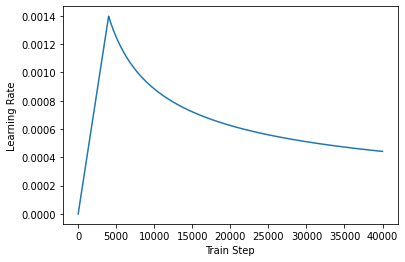

In [51]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [0]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [0]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [0]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

In [0]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [0]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)
  
  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)
  
  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

In [0]:
#checkpoint_path = "./checkpoints/train"
checkpoint_path = checkpoint_dir + "/" + input_language + "_" + target_language 

ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [0]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

#@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar_real, predictions)

In [0]:
EPOCHS = 1

In [61]:
for epoch in range(EPOCHS):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_dataset):
    train_step(inp, tar)
    
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

InvalidArgumentError: ignored

In [0]:
def evaluate(inp_sentence):
  #tokenizer_input_lang, tokenizer_target_lang
  start_token = [tokenizer_input_lang.vocab_size]
  end_token = [tokenizer_input_lang.vocab_size + 1]
  
  # inp sentence is portuguese, hence adding the start and end token
  inp_sentence = start_token + tokenizer_input_lang.encode(inp_sentence) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)
  
  # as the target is english, the first word to the transformer should be the
  # english start token.
  decoder_input = [tokenizer_target_lang.vocab_size]
  output = tf.expand_dims(decoder_input, 0)
    
  for i in range(MAX_LENGTH):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
  
    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    
    # select the last word from the seq_len dimension
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # return the result if the predicted_id is equal to the end token
    if predicted_id == tokenizer_target_lang.vocab_size+1:
      return tf.squeeze(output, axis=0), attention_weights
    
    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0), attention_weights

In [0]:
def translate(sentence, plot=''):
  result, attention_weights = evaluate(sentence)
  
  predicted_sentence = tokenizer_target_lang.decode([i for i in result if i < tokenizer_target_lang.vocab_size])  

  print('Input: {}'.format(sentence))
  print('Predicted translation: {}'.format(predicted_sentence))
  
  if plot:
    plot_attention_weights(attention_weights, sentence, result, plot)

In [64]:
translate(sentence = "je suis l'alpha et l'omega.", plot='')
translate(sentence = 'le premier et le dernier.', plot='')
translate(sentence = 'le commencement et la fin', plot='')
translate(sentence = 'il a venge le sang de ses serviteurs repandu par ses mains.', plot='')
translate(sentence = "et ils dirent une seconde fois alleluia.", plot='')

Input: je suis l'alpha et l'omega.
Predicted translation: performedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformedperformed
Input: le prem

<tf.Tensor: shape=(104,), dtype=int32, numpy=
array([8633, 6131, 6131, 6131, 6131, 6131, 6131, 6131, 6131, 6131, 6131,
       6131, 6131, 6131, 6131, 6131, 6131, 6131, 6131, 6131, 6131, 6131,
       6131, 6131, 6131, 6131, 6131, 6131, 6131, 6131, 6131, 6131, 6131,
       6131, 6131, 6131, 6131, 6131, 6131, 6131, 6131, 6131, 6131, 6131,
       6131, 6131, 6131, 6131, 6131, 6131, 6131, 6131, 6131, 6131, 6131,
       6131, 6131, 6131, 6131, 6131, 6131, 6131, 6131, 6131, 6131, 6131,
       6131, 6131, 6131, 6131, 6131, 6131, 6131, 6131, 6131, 6131, 6131,
       6131, 6131, 6131, 6131, 6131, 6131, 6131, 6131, 6131, 6131, 6131,
       6131, 6131, 6131, 6131, 6131, 6131, 6131, 6131, 6131, 6131, 6131,
       6131, 6131, 6131, 6131, 6131], dtype=int32)>

In [0]:
class Trainer() :
  def __init__(self, 
    input_language, 
    target_language, 
    path_to_dataset, 
    vocab_dir,
    dir_model,
    checkpoint_dir,

    # to load dataset
    # todo : faire en sorte que le dataset ne soit charger que si on fait le build, et non la restauration
    # ie : faire en sorte que ces parametres soient construire et sauvegarder lors du build
    sentencesSeparator = '__SEPARATOR__',
    
    test_size = 0, # le model est évalué directement lors du train, pas besoin des données de test comme dans l'ancien model (v1.0)
    val_size = 0.1, # nous avons besoin des données de validation
    num_examples = None,
    MAX_LENGTH = 40, 
    BUFFER_SIZE = 20000, 
    BATCH_SIZE = 64, 
    target_vocab_size = 2**13
    ):

    self.input_language = input_language
    self.target_language = target_language
    self.path_to_dataset = path_to_dataset
    self.vocab_dir = vocab_dir
    self.dir_model = dir_model
    self.checkpoint_dir = checkpoint_dir
    self.sentencesSeparator = sentencesSeparator
    self.num_examples = num_examples 

    self.test_size = test_size
    self.val_size = val_size
    self.num_examples = num_examples
    self.MAX_LENGTH = MAX_LENGTH 
    self.BUFFER_SIZE = BUFFER_SIZE 
    self.BATCH_SIZE = BATCH_SIZE 
    self.target_vocab_size = target_vocab_size

    self.train_dataset, self.val_dataset, self.test_dataset, self.tokenizer_input_lang, self.tokenizer_target_lang, metadata = load_dataset(
      path = self.path_to_dataset, 
      sentencesSeparator = self.sentencesSeparator,
      input_vocab_filename = self.vocab_dir + "/"+ self.input_language, 
      target_vocab_filename = self.vocab_dir + "/"+ self.target_language, 
      MAX_LENGTH = self.MAX_LENGTH, 
      BUFFER_SIZE = self.BUFFER_SIZE, 
      BATCH_SIZE = self.BATCH_SIZE, 
      target_vocab_size = self.target_vocab_size,
      test_size = self.test_size, 
      val_size = self.val_size,
      num_examples = self.num_examples
    )

    self.MAX_LENGTH = metadata["max_length"]
    self.BUFFER_SIZE = metadata["buffer_size"]

    self.input_vocab_size = tokenizer_input_lang.vocab_size + 2
    self.target_vocab_size = tokenizer_target_lang.vocab_size + 2
  
  def build(self, num_layers = 6, d_model = 512, dff = 2048, num_heads = 8, dropout_rate = 0.1):

    self.num_layers = num_layers
    self.d_model = num_layers
    self.dff = num_layers
    self.num_heads = num_layers
    self.dropout_rate = dropout_rate

    # Optimizer
    self.learning_rate = CustomSchedule(d_model)
    self.optimizer = tf.keras.optimizers.Adam(self.learning_rate, beta_1 = 0.9, beta_2 = 0.98, epsilon = 1e-9)

    # Loss and metrics
    self.loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = 'none')
    self.train_loss = tf.keras.metrics.Mean(name = 'train_loss')
    self.train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name = 'train_accuracy')

    # Create the model
    self.transformer = Transformer(num_layers = self.num_layers, d_model = self.d_model, num_heads = self.num_heads, dff = self.dff,
                                  input_vocab_size = self.input_vocab_size, target_vocab_size = self.target_vocab_size, 
                                  pe_input = self.input_vocab_size, pe_target = self.target_vocab_size, rate = self.dropout_rate)


    # Create the checkpoint path and the checkpoint manager. This will be used to save checkpoints every n epochs.

    checkpoint_path = self.checkpoint_dir + "/" + self.input_language + "_" + self.target_language 
    ckpt = tf.train.Checkpoint(transformer = self.transformer, optimizer = self.optimizer)
    self.ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

    # if a checkpoint exists, restore the latest checkpoint.
    if self.ckpt_manager.latest_checkpoint:
      ckpt.restore(ckpt_manager.latest_checkpoint)
      print ('Latest checkpoint restored!!')

  def restore(self):
    # todo : recuperer tout les attributs utiliser par evaluate, translate, plot attention
    """
    self.tokenizer_input_lang
    self.tokenizer_target_lang
    self.transformer
    self.MAX_LENGTH
    """
    #self.transformer = tf.keras.Model.load(self.dir_model+ "/" + self.input_language + "_" + self.target_language + ".h5")
    pass

  

  # loss_function
  def loss_function(self, real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = self.loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

  """
  The @tf.function trace-compiles train_step into a TF graph for faster execution. 
  The function specializes to the precise shape of the argument tensors. 
  To avoid re-tracing due to the variable sequence lengths or variable batch sizes (the last batch is smaller), 
  use input_signature to specify more generic shapes.
  """
  """
  @tf.function(input_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
  ])
  """
  def train_step(self, inp, tar):
    """
    The target is divided into tar_inp and tar_real. tar_inp is passed as an input to the decoder. 
    tar_real is that same input shifted by 1: At each location in tar_input, tar_real contains the next token that should be predicted.

    For example, sentence = "SOS A lion in the jungle is sleeping EOS"
    tar_inp = "SOS A lion in the jungle is sleeping"
    tar_real = "A lion in the jungle is sleeping EOS"

    The transformer is an auto-regressive model: it makes predictions one part at a time, and uses its output so far to decide what to do next.
    During training this example uses teacher-forcing. Teacher forcing is passing the true output to the next 
    time step regardless of what the model predicts at the current time step.

    As the transformer predicts each word, self-attention allows it to look at the previous words in the input sequence to better predict the next word.
    To prevent the model from peaking at the expected output the model uses a look-ahead mask.
    """
    print(inp)
    print("inp - tar")
    print(tar)
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
    print("mask ok")

    with tf.GradientTape() as tape:
      predictions, _ = self.transformer(inp, tar_inp, True, enc_padding_mask, combined_mask, dec_padding_mask)
      loss = self.loss_function(tar_real, predictions)
    print("tf.GradientTape() ok")
    gradients = tape.gradient(loss, self.transformer.trainable_variables)    
    self.optimizer.apply_gradients(zip(gradients, self.transformer.trainable_variables))
    print("optimizer ok")
    self.train_loss(loss)
    self.train_accuracy(tar_real, predictions)
    print("train step ok")

  def train(self, EPOCHS=10):
    for epoch in range(EPOCHS):
      start = time.time()
      
      self.train_loss.reset_states()
      self.train_accuracy.reset_states()
      
      # inp -> input_language, tar -> target_language
      for (batch, (inp, tar)) in enumerate(self.train_dataset):
        self.train_step(inp, tar)
        
        if batch % 100 == 0:
          print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
              epoch + 1, batch, self.train_loss.result(), self.train_accuracy.result()))
          
      if (epoch + 1) % 5 == 0:
        ckpt_save_path = self.ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                             ckpt_save_path))
      print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                    self.train_loss.result(), 
                                                    self.train_accuracy.result()))

      print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

    # todo 
    # self.transformer.save(self.dir_model+ "/" + self.input_language + "_" + self.target_language + ".h5")


  def evaluate(self, inp_sentence):
    """
    The following steps are used for evaluation:
    - Encode the input sentence using the Portuguese tokenizer (tokenizer_pt). Moreover, add the start and end token so the input is equivalent to what the model is trained with. This is the encoder input.
    - The decoder input is the start token == tokenizer_en.vocab_size.
    - Calculate the padding masks and the look ahead masks.
    - The decoder then outputs the predictions by looking at the encoder output and its own output (self-attention).
    - Select the last word and calculate the argmax of that.
    - Concatentate the predicted word to the decoder input as pass it to the decoder.
    - In this approach, the decoder predicts the next word based on the previous words it predicted.
    """
    start_token = [self.tokenizer_input_lang.vocab_size]
    end_token = [self.tokenizer_input_lang.vocab_size + 1]
  
    # inp sentence is input_language, hence adding the start and end token
    inp_sentence = start_token + self.tokenizer_input_lang.encode(inp_sentence) + end_token
    encoder_input = tf.expand_dims(inp_sentence, 0)
    
    # as the target is target_language, the first word to the transformer should be the target_language start token.
    decoder_input = [self.tokenizer_target_lang.vocab_size]
    output = tf.expand_dims(decoder_input, 0)
      
    for i in range(self.MAX_LENGTH):
      enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)
    
      # predictions.shape == (batch_size, seq_len, vocab_size)
      predictions, attention_weights = self.transformer(inp = encoder_input, 
                                                   tar = output,
                                                   training = False,
                                                   enc_padding_mask = enc_padding_mask,
                                                   look_ahead_mask = combined_mask,
                                                   dec_padding_mask = dec_padding_mask)
      
      # select the last word from the seq_len dimension
      predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

      predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
      
      # return the result if the predicted_id is equal to the end token
      if predicted_id == self.tokenizer_target_lang.vocab_size+1:
        return tf.squeeze(output, axis=0), attention_weights
      
      # concatentate the predicted_id to the output which is given to the decoder as its input.
      output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights

  def plot_attention_weights(self, attention, sentence, result, layer):
    fig = plt.figure(figsize=(16, 8))
    
    sentence = self.tokenizer_input_lang.encode(sentence)
    
    attention = tf.squeeze(attention[layer], axis=0)
    
    for head in range(attention.shape[0]):
      ax = fig.add_subplot(2, 4, head+1)
      
      # plot the attention weights
      ax.matshow(attention[head][:-1, :], cmap='viridis')

      fontdict = {'fontsize': 10}
      
      ax.set_xticks(range(len(sentence)+2))
      ax.set_yticks(range(len(result)))
      
      ax.set_ylim(len(result)-1.5, -0.5)
          
      ax.set_xticklabels(
          [SOS]+[self.tokenizer_input_lang.decode([i]) for i in sentence]+[EOS], 
          fontdict=fontdict, rotation=90)
      
      ax.set_yticklabels([self.tokenizer_target_lang.decode([i]) for i in result 
                          if i < self.tokenizer_target_lang.vocab_size], 
                         fontdict=fontdict)
      
      ax.set_xlabel('Head {}'.format(head+1))
    
    plt.tight_layout()
    plt.show()

  def translate(self, sentence, plot = ''):
    result, attention_weights = self.evaluate(sentence)
    predicted_sentence = self.tokenizer_target_lang.decode([i for i in result if i < self.tokenizer_target_lang.vocab_size])  

    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(predicted_sentence))
    
    if plot:
      plot_attention_weights(attention_weights, sentence, result, plot)

    return result

In [0]:
input_language = "Francais"
target_language = "Anglais"
path_to_dataset = "/content/drive/My Drive/datasets/YourVersion/txts/"+input_language+"_" +target_language +"_pnb1.txt"
vocab_dir = "/content/drive/My Drive/datasets/YourVersion/vocab_dir"
dir_model = "/content/drive/My Drive/datasets/YourVersion/dir_model"
checkpoint_dir =  "/content/drive/My Drive/datasets/YourVersion/checkpoint_dir"

In [0]:
t = Trainer(
    input_language = input_language, 
    target_language = target_language, 
    path_to_dataset = path_to_dataset, 
    vocab_dir = vocab_dir,
    dir_model = dir_model,
    checkpoint_dir = checkpoint_dir,
    num_examples = None
  )

In [40]:
input_batch, target_batch = next(iter(t.val_dataset))
input_batch, target_batch

(<tf.Tensor: shape=(64, 103), dtype=int32, numpy=
 array([[ 558,  168,    1, ...,    0,    0,    0],
        [  37,   75,  306, ...,    0,    0,    0],
        [  19,    9,    8, ...,    0,    0,    0],
        ...,
        [  19,    9,   67, ...,    0,    0,    0],
        [ 575,    1, 2971, ...,    0,    0,    0],
        [  19,  706,    1, ...,    0,    0,    0]], dtype=int32)>,
 <tf.Tensor: shape=(64, 103), dtype=int32, numpy=
 array([[1139,  173,    1, ...,    0,    0,    0],
        [  60,  103, 1093, ...,    0,    0,    0],
        [  59,   34,  280, ...,    0,    0,    0],
        ...,
        [  35,   66,  207, ...,    0,    0,    0],
        [   3,   43,   18, ...,    0,    0,    0],
        [ 153,  123,    1, ...,    0,    0,    0]], dtype=int32)>)

In [0]:
t.build()

In [39]:
t.train(EPOCHS=20)

tf.Tensor(
[[ 100 5588    4 ...    0    0    0]
 [  19   43 1527 ...    0    0    0]
 [  19 2967   12 ...    0    0    0]
 ...
 [ 441 3572   20 ...    0    0    0]
 [   9 4028    1 ...    0    0    0]
 [  43 2054    7 ...    0    0    0]], shape=(64, 103), dtype=int32)
inp - tar
tf.Tensor(
[[ 337 7963 7894 ...    0    0    0]
 [2570 4499 7900 ...    0    0    0]
 [ 136 7894    6 ...    0    0    0]
 ...
 [ 169    9 4653 ...    0    0    0]
 [3915  268    1 ...    0    0    0]
 [  69 4931  203 ...    0    0    0]], shape=(64, 103), dtype=int32)
mask ok


InvalidArgumentError: ignored

In [0]:
t.restore()

In [0]:
t.translate("je suis l'alpha et l'omega.")
t.translate('le premier et le dernier.')
t.translate('le commencement et la fin')
t.translate('il a venge le sang de ses serviteurs repandu par ses mains.')
t.translate("et ils dirent une seconde fois alleluia.")